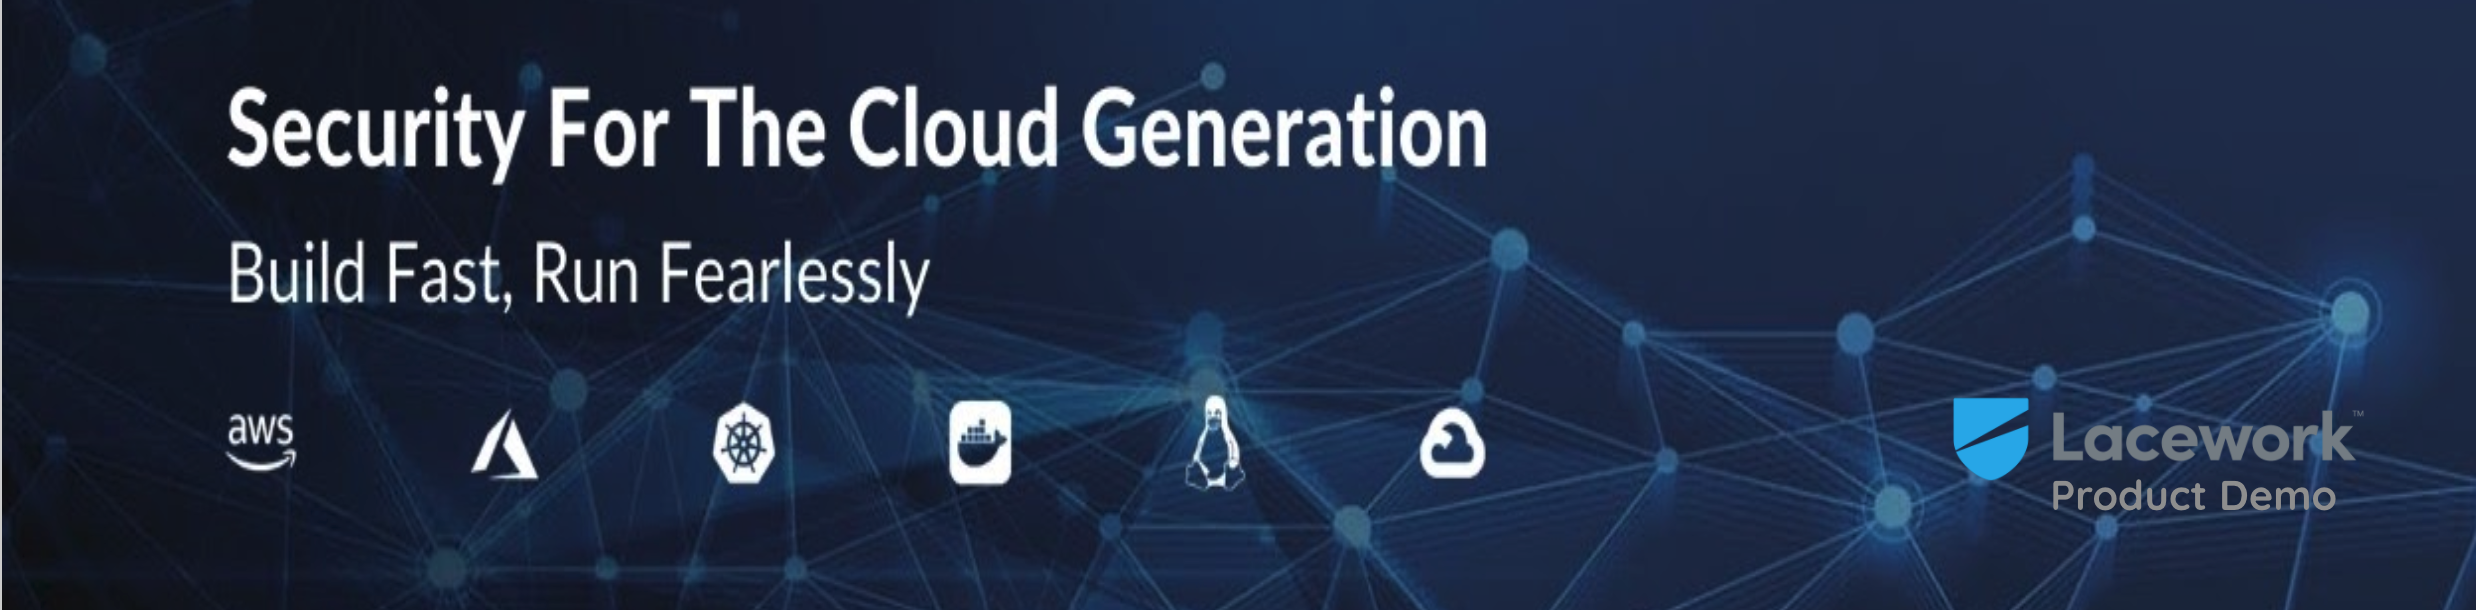

**setup**

In [ ]:
export apiKey="/Users/larryebaum/.customerdemo_larryebaum_apiKey.json"
export prefixName="larryebaum"

### **Lacework Query Language (LQL) Overview**

Lacework supports the following types of custom policies:
- Policies that invoke LQL queries on Lacework datasets.
- Policies that are cloned and created in the Lacework Console and contain AND conditions. These policies were previously known as custom rules. 
Lacework also ships with a set of default LQL policies that are available from Policies in the Lacework Console. To view all the policies in your Lacework instance, click Policies in the left navigation panel. To view the LQL query associated with a policy, click the policy name.  

For example, to view the VPC Change LQL policy, select Policies and enter VPC Change in the search field.  
To view the LQL query that is called by the VPC Change, click VPC Change in the list.

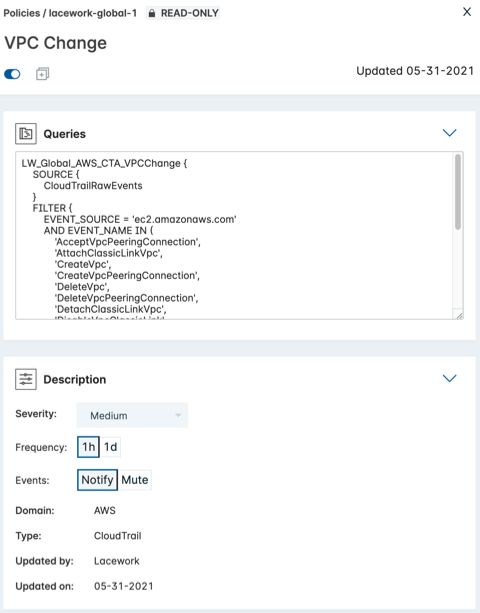  
You can use these default queries as the basis for your LQL queries. Example LQL Queries and Policies lists some additional example queries and policies.

**Definitions**  
A query is a mechanism used to interactively request information from a specific curated dataset. A query has a defined structure for authoring detections.  
A policy is a mechanism used to add annotated metadata to the query for improving the context of alerts, reports, and information displayed in the Lacework Console. A policy can be fully customized.  

The lacework configure command is the fastest way to set up your Lacework CLI installation. The following command reads the downloaded JSON file and sets up a default configuration for the CLI.

### **Create Queries & Custom Policies via API**  

**Create API Key & Temporary API Token**

To create an API key, navigate to Settings > API Keys and click + Create New. Enter a name for the key and an optional description and click Save. To get the secret key, download the generated API key file and open it in an editor.

In [ ]:
cat ~/.customerfake_example_apiKey.json

After creating a secret key, administrators can generate temporary API access (bearer) tokens that are used by clients and client applications to access the Lacework API. Temporary API access (bearer) tokens are created using the POST api/v1/access/tokens operation of the Lacework API.


In [ ]:
export apiSecret=$(jq -r .secret $apiKey)
export apiKeyId=$(jq -r .keyId $apiKey)
export apiAccount=$(jq -r .account $apiKey)
curl -H "X-LW-UAKS:$apiSecret" -H "Content-Type: application/json" -X POST -d "{\"keyId\": \"$apiKeyId\", \"expiryTime\":3600}" https://$apiAccount/api/v1/access/tokens > token.json

In [ ]:
jq -r .data token.json | jq .[0].token | tr -d '"'

In [ ]:
export token=$(jq -r .data token.json | jq .[0].token | tr -d '""')

### **Queries**

**What Queries Exist**

In [ ]:
curl --location --request GET "https://$apiAccount/api/v2/Queries" \
--header 'Content-Type: application/json' \
--header "Authorization: Bearer $token" | jq '.data |.[].queryId'

Let's see what kind of data we can get back if we use a test query such as:  
`{`  
 `"queryText": "larryebaum_deleteme_Custom_AWS_CTA_Simple {source {CloudTrailRawEvents} return {INSERT_ID,INSERT_TIME,EVENT_TIME,EVENT}}",`  
  `"evaluatorId": "Cloudtrail",`  
  `"queryId": "SueK_Custom_AWS_CTA_Simple"`  
`}`

**Create Our Query**

In [ ]:
curl --location --request POST "https://$apiAccount/api/v2/Queries" \
--header 'Content-Type: application/json' \
--header "Authorization: Bearer $token" \
--data-raw "{ \"queryText\": \"${prefixName}_deleteme_Custom_AWS_CTA_Simple {source {CloudTrailRawEvents} return {INSERT_ID,INSERT_TIME,EVENT_TIME,EVENT}}\", \"evaluatorId\": \"Cloudtrail\", \"queryId\": \"${prefixName}_deleteme_Custom_AWS_CTA_Simple\" }" | jq  

**Execute the query** and write output to a file

In [ ]:
curl --location --request POST "https://${apiAccount}/api/v2/Queries/${prefixName}_deleteme_Custom_AWS_CTA_Simple/execute" \
--header 'Content-Type: application/json' \
--header "Authorization: Bearer $token" \
--data-raw '{ "arguments": [ {"name": "StartTimeRange", "value": "2021-07-18T00:00:00.000Z"}, {"name": "EndTimeRange", "value": "2021-07-19T00:00:00.000Z"} ] }' > queryOut.json

**Refine the query using filters**  
Update the query using PATCH `../api/v2/Queries/{queryId}` endpoint and replacing `{queryId}` with the query ID. Pass in the LQL query using the `queryText` JSON field of the `body` input parameter.

In [ ]:
curl --location --request PATCH "https://${apiAccount}/api/v2/Queries/${prefixName}_deleteme_Custom_AWS_CTA_Simple" \
--header 'Content-Type: application/json' \
--header "Authorization: Bearer $token" \
--data-raw '{"queryText": "'""${prefixName}'_deleteme_Custom_AWS_CTA_Simple {source {CloudTrailRawEvents} filter {EVENT_SOURCE = '\''ec2.amazonaws.com'\'' and EVENT_NAME = '\''CreateVpc'\''} return {INSERT_ID,INSERT_TIME,EVENT_TIME,EVENT}}"}'

**Execute the updated query** and write output to a file

In [ ]:
curl --location --request POST "https://${apiAccount}/api/v2/Queries/${prefixName}_deleteme_Custom_AWS_CTA_Simple/execute" \
--header 'Content-Type: application/json' \
--header "Authorization: Bearer $token" \
--data-raw '{ "arguments": [ {"name": "StartTimeRange", "value": "2021-07-18T00:00:00.000Z"}, {"name": "EndTimeRange", "value": "2021-07-19T00:00:00.000Z"} ] }' >filterOut.json    

### **Policies**
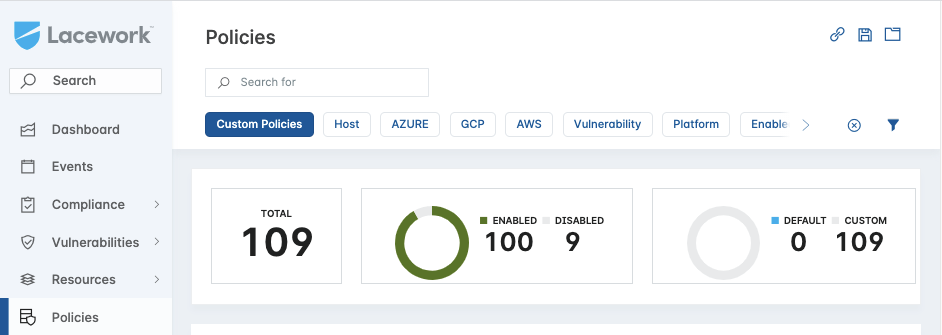  
  
Policies are used to invoke queries on a defined interval, and if the query returns data, invoke an alert.  

**What Policies Exist**

In [ ]:
curl --location --request GET "https://${apiAccount}/api/v2/Policies" \
--header 'Content-Type: application/json' \
--header "Authorization: Bearer $token"

**Create a policy that invokes the query**  

In [ ]:
curl --location --request POST "https://${apiAccount}/api/v2/Policies" \
--header "Authorization: Bearer $token" \
--header 'Content-Type: application/json' \
--data-raw "{
\"policyType\": \"Violation\",
\"queryId\": \"${prefixName}_deleteme_Global_AWS_CTA_Simple\",
\"title\": \"${prefixName}_New VPC Created\",
\"enabled\": true,
\"description\": \"A new VPC was created\",
\"remediation\": \"Check that the new VPC was expected.\",
\"severity\": \"high\",
\"limit\": 1000,
\"alertEnabled\": true,
\"evalFrequency\": \"Hourly\",
\"alertProfile\": \"${prefixName}_LW_CloudTrail_Alerts\",
\"policyUi\": {
    \"domain\": \"AWS\",
    \"subdomain\": \"Cloudtrail\"
},
\"evaluatorId\": \"Cloudtrail\"
}"    

**END**

**cleanup**

In [ ]:
curl --location --request DELETE "https://${apiAccount}/api/v2/Queries/${prefixName}_deleteme_Custom_AWS_CTA_Simple" --header 'Content-Type: application/json' --header "Authorization: Bearer $token"

In [ ]:
#curl --location --request DELETE "https://$apiAccount/api/v2/Policies/larryebaum_deleteme_Custom_AWS_CTA_Simple" --header 'Content-Type: application/json' --header "Authorization: Bearer $token"

In [ ]:
rm token.json
rm queryOut.json
rm filterOut.json